# Building Efficient Lightweight CNN Models on CIFAR-10
## Reproduction of arXiv:2501.15547 and Lightweight Extensions

This notebook first reproduces the base paper "Building Efficient Lightweight CNN Models" and then implements a compact set of **improvements** (residual + SE backbone, Mixup/CutMix augmentation, warmup-cosine AdamW schedule, and label-smoothing regularization) suitable for the final project report.


## 1. Imports and Setup


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configure matplotlib for publication-quality plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")


TensorFlow version: 2.19.0
GPU Available: []


In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph


def compute_model_flops(model, input_shape=(1, 32, 32, 3)):
    """Estimate FLOPs for a Keras model."""
    inputs = tf.TensorSpec(input_shape, tf.float32)
    concrete = tf.function(model).get_concrete_function(inputs)
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, options=opts)
    return flops.total_float_ops if flops is not None else 0


def measure_inference_time(model, sample_batch, repeats=50):
    """Measure average inference time in seconds."""
    times = []
    for _ in range(repeats):
        start = time.time()
        _ = model.predict(sample_batch, verbose=0)
        times.append(time.time() - start)
    return float(np.mean(times))



In [ ]:
class WarmupCosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, total_steps, warmup_steps):
        super().__init__()
        self.base_lr = base_lr
        self.total_steps = total_steps
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        if self.warmup_steps > 0:
            warmup_lr = self.base_lr * (step / tf.cast(self.warmup_steps, tf.float32))
            cosine_lr = 0.5 * self.base_lr * (1 + tf.cos(
                np.pi * (step - self.warmup_steps) /
                tf.cast(self.total_steps - self.warmup_steps + 1e-8, tf.float32)
            ))
            return tf.where(step < self.warmup_steps, warmup_lr, cosine_lr)
        cosine_lr = 0.5 * self.base_lr * (1 + tf.cos(np.pi * step / tf.cast(self.total_steps, tf.float32)))
        return cosine_lr


class DropoutScheduler(callbacks.Callback):
    def __init__(self, layer_names, max_rate=0.4, min_rate=0.2, total_epochs=50):
        super().__init__()
        self.layer_names = layer_names
        self.max_rate = max_rate
        self.min_rate = min_rate
        self.total_epochs = total_epochs

    def on_epoch_begin(self, epoch, logs=None):
        progress = epoch / max(1, self.total_epochs - 1)
        new_rate = self.max_rate - (self.max_rate - self.min_rate) * progress
        for name in self.layer_names:
            if name in [layer.name for layer in self.model.layers]:
                self.model.get_layer(name).rate = float(new_rate)



In [ ]:
import math


class MixupCutmixGenerator(keras.utils.Sequence):
    def __init__(self, x, y, batch_size=128, mixup_alpha=0.2, cutmix_alpha=1.0, cutmix_prob=0.5, shuffle=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.cutmix_prob = cutmix_prob
        self.shuffle = shuffle
        self.indices = np.arange(len(self.x))
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = self.x[batch_indices].copy()
        batch_y = self.y[batch_indices].copy()
        if len(batch_x) < 2:
            return batch_x, batch_y
        if np.random.rand() < self.cutmix_prob:
            return self._apply_cutmix(batch_x, batch_y)
        return self._apply_mixup(batch_x, batch_y)

    def _sample_beta(self, alpha):
        return np.random.beta(alpha, alpha)

    def _apply_mixup(self, x, y):
        lam = self._sample_beta(self.mixup_alpha)
        indices = np.random.permutation(len(x))
        mixed_x = lam * x + (1 - lam) * x[indices]
        mixed_y = lam * y + (1 - lam) * y[indices]
        return mixed_x, mixed_y

    def _rand_bbox(self, size, lam):
        h, w = size[1], size[2]
        cut_rat = np.sqrt(1. - lam)
        cut_w = int(w * cut_rat)
        cut_h = int(h * cut_rat)

        cx = np.random.randint(w)
        cy = np.random.randint(h)

        x1 = np.clip(cx - cut_w // 2, 0, w)
        x2 = np.clip(cx + cut_w // 2, 0, w)
        y1 = np.clip(cy - cut_h // 2, 0, h)
        y2 = np.clip(cy + cut_h // 2, 0, h)
        return x1, y1, x2, y2

    def _apply_cutmix(self, x, y):
        lam = self._sample_beta(self.cutmix_alpha)
        indices = np.random.permutation(len(x))
        shuffled_x = x[indices]
        shuffled_y = y[indices]
        x1, y1, x2, y2 = self._rand_bbox(x.shape, lam)
        x[:, y1:y2, x1:x2, :] = shuffled_x[:, y1:y2, x1:x2, :]
        lam_adjusted = 1 - ((x2 - x1) * (y2 - y1) / (x.shape[1] * x.shape[2]))
        y = lam_adjusted * y + (1 - lam_adjusted) * shuffled_y
        return x, y



In [ ]:
def squeeze_excite_block(inputs, ratio=16, name_prefix='se'):
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling2D(name=f'{name_prefix}_gap')(inputs)
    se = layers.Dense(filters // ratio, activation='relu', name=f'{name_prefix}_fc1')(se)
    se = layers.Dense(filters, activation='sigmoid', name=f'{name_prefix}_fc2')(se)
    se = layers.Reshape((1, 1, filters), name=f'{name_prefix}_reshape')(se)
    return layers.Multiply(name=f'{name_prefix}_scale')([inputs, se])


def residual_block(inputs, filters, kernel_size=(3, 3), name_prefix='res', use_se=False):
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=None, name=f'{name_prefix}_conv1')(inputs)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn1')(x)
    x = layers.ReLU(name=f'{name_prefix}_relu1')(x)
    x = layers.Conv2D(filters, kernel_size, padding='same', activation=None, name=f'{name_prefix}_conv2')(x)
    x = layers.BatchNormalization(name=f'{name_prefix}_bn2')(x)
    if use_se:
        x = squeeze_excite_block(x, ratio=16, name_prefix=f'{name_prefix}_se')
    if inputs.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, (1, 1), padding='same', name=f'{name_prefix}_shortcut')(inputs)
        shortcut = layers.BatchNormalization(name=f'{name_prefix}_shortcut_bn')(shortcut)
    else:
        shortcut = inputs
    x = layers.Add(name=f'{name_prefix}_add')([x, shortcut])
    x = layers.ReLU(name=f'{name_prefix}_relu2')(x)
    return x


def build_residual_lightweight_model(use_se=False, dropout_rate=0.3, num_classes=10):
    inputs = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(16, (3, 3), padding='same', activation='relu', name='stem_conv')(inputs)
    x = layers.MaxPooling2D((2, 2), name='stem_pool')(x)

    x = residual_block(x, 32, name_prefix='block1', use_se=use_se)
    x = layers.MaxPooling2D((2, 2), name='block1_pool')(x)

    x = residual_block(x, 64, name_prefix='block2', use_se=use_se)
    x = layers.GlobalAveragePooling2D(name='global_pool')(x)

    x = layers.Dense(128, activation='relu', name='dense_proj')(x)
    x = layers.Dropout(dropout_rate, name='improved_dropout')(x)
    outputs = layers.Dense(num_classes, activation='softmax', name='improved_output')(x)
    return models.Model(inputs, outputs, name='residual_lightweight_model')



In [ ]:
def train_and_evaluate_model(model, train_data, val_data, test_data, epochs=30, batch_size=128,
                             optimizer=None, loss_fn=None, callbacks_list=None, class_weights=None,
                             variant_name='Variant'):
    if optimizer is None:
        optimizer = optimizers.Adam(learning_rate=0.001)
    if loss_fn is None:
        loss_fn = keras.losses.CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        batch_size=batch_size if not isinstance(train_data, keras.utils.Sequence) else None,
        callbacks=callbacks_list or [],
        class_weight=class_weights,
        verbose=1
    )
    training_time = time.time() - start_time

    test_metrics = model.evaluate(test_data[0], test_data[1], verbose=0)
    y_pred = model.predict(test_data[0], verbose=0)
    y_true = np.argmax(test_data[1], axis=1)
    y_pred_classes = np.argmax(y_pred, axis=1)

    return {
        'model': model,
        'history': history,
        'training_time': training_time,
        'test_loss': float(test_metrics[0]),
        'test_accuracy': float(test_metrics[1]),
        'y_true': y_true,
        'y_pred_classes': y_pred_classes,
        'y_pred_probs': y_pred
    }



In [ ]:
def plot_history(history, title_prefix, save_path=None):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    axes[0].plot(history.history['accuracy'], label='Train', linewidth=2)
    axes[0].plot(history.history['val_accuracy'], label='Val', linewidth=2, linestyle='--')
    axes[0].set_title(f'{title_prefix} - Accuracy', fontsize=14)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()

    axes[1].plot(history.history['loss'], label='Train', linewidth=2)
    axes[1].plot(history.history['val_loss'], label='Val', linewidth=2, linestyle='--')
    axes[1].set_title(f'{title_prefix} - Loss', fontsize=14)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()



In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels, title, save_path=None):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()



In [ ]:
def log_experiment(name, result_dict):
    params = count_parameters(result_dict['model'])
    size_mb = get_model_size_mb(result_dict['model'])
    flops = compute_model_flops(result_dict['model'])
    inference_time = measure_inference_time(result_dict['model'], x_test[:1])
    experiment_records.append({
        'model': name,
        'variant': name,
        'test_acc': result_dict['test_accuracy'],
        'params': params,
        'train_time_s': result_dict['training_time'],
        'infer_time_ms': inference_time * 1000,
        'model_size_mb': size_mb,
        'flops': flops
    })
    return params, size_mb, flops, inference_time


In [ ]:
def measure_latency_stats(model, sample, repeats=50, device='/CPU:0'):
    timings = []
    for _ in range(repeats):
        start = time.time()
        with tf.device(device):
            _ = model.predict(sample, verbose=0)
        timings.append(time.time() - start)
    timings = np.array(timings)
    return {
        'mean_ms': float(timings.mean() * 1000),
        'p50_ms': float(np.percentile(timings, 50) * 1000),
        'p90_ms': float(np.percentile(timings, 90) * 1000),
        'p99_ms': float(np.percentile(timings, 99) * 1000)
    }



In [ ]:
def compute_training_throughput(num_samples, training_time_s):
    return num_samples / training_time_s if training_time_s > 0 else 0.0



In [ ]:
def get_gpu_memory_info():
    gpus = tf.config.list_physical_devices('GPU')
    if not gpus:
        return {'current': None, 'peak': None}
    try:
        info = tf.config.experimental.get_memory_info('GPU:0')
        return {'current': info['current'] / (1024 ** 2), 'peak': info['peak'] / (1024 ** 2)}
    except Exception:
        return {'current': None, 'peak': None}



## 2. Data Loading and Preprocessing


In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Convert labels to categorical
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")
print(f"\nClass distribution in training set:")
for i, name in enumerate(class_names):
    print(f"  {name}: {np.sum(y_train == i)}")


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)

Class distribution in training set:
  airplane: 5000
  automobile: 5000
  bird: 5000
  cat: 5000
  deer: 5000
  dog: 5000
  frog: 5000
  horse: 5000
  ship: 5000
  truck: 5000


## 3. Baseline Implementation - Stage 1: Dual-Input-Output Model

### 3.1 Model Architecture Definition

The baseline architecture consists of two identical sub-models that will be trained separately:
- Model 1: Trained on original data
- Model 2: Trained on augmented data


In [ ]:
def create_base_model():
    """
    Create the base CNN model architecture as specified in the paper.
    Architecture:
    - Input: [32, 32, 3] for CIFAR-10
    - Conv2D: 10 filters, 3x3 kernel, ReLU, same padding
    - MaxPooling2D: 2x2 pool size
    - Conv2D: 20 filters, 3x3 kernel, ReLU, same padding
    - MaxPooling2D: 2x2 pool size
    - Flatten
    - Dense: 128 units, ReLU
    - Dropout: 0.3
    - Dense: 10 units, softmax (for 10 classes)
    """
    model = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(10, (3, 3), activation='relu', padding='same', name='conv1'),
        layers.MaxPooling2D((2, 2), name='pool1'),
        layers.Conv2D(20, (3, 3), activation='relu', padding='same', name='conv2'),
        layers.MaxPooling2D((2, 2), name='pool2'),
        layers.Flatten(name='flatten'),
        layers.Dense(128, activation='relu', name='dense1'),
        layers.Dropout(0.3, name='dropout'),
        layers.Dense(10, activation='softmax', name='output')
    ])
    return model

# Create two identical models
model1 = create_base_model()
model2 = create_base_model()

print("Model 1 Architecture:")
model1.summary()
print("\n" + "="*80 + "\n")
print("Model 2 Architecture:")
model2.summary()


Model 1 Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 10)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 16, 16, 20)     │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,358 (653.74 KB)

 Trainable params: 167,358 (653.74 KB)

 Non-trainable params: 0 (0.00 B)



Model 2 Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 32, 32, 10)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 16, 16, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 16, 16, 20)     │         1,820 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 8, 8, 20)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,358 (653.74 KB)

 Trainable params: 167,358 (653.74 KB)

 Non-trainable params: 0 (0.00 B)

### 3.2 Data Augmentation Setup

Model 2 will be trained with augmented data using ImageDataGenerator.


In [ ]:
# Create data augmentation generator for model2
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Create generators for training and validation
train_gen1 = datagen.flow(x_train, y_train_cat, batch_size=128, subset='training', shuffle=False)
val_gen1 = datagen.flow(x_train, y_train_cat, batch_size=128, subset='validation', shuffle=False)

# For model1, use original data (no augmentation)
train_gen2 = datagen.flow(x_train, y_train_cat, batch_size=128, subset='training', shuffle=True)
val_gen2 = datagen.flow(x_train, y_train_cat, batch_size=128, subset='validation', shuffle=False)

print("Data generators created successfully!")


Data generators created successfully!


### 3.3 Training Stage 1 - Model 1 (Original Data)


In [ ]:
# Compile model1
model1.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Calculate validation split
val_split_idx = int(len(x_train) * 0.2)
x_train1 = x_train[val_split_idx:]
y_train1 = y_train_cat[val_split_idx:]
x_val1 = x_train[:val_split_idx]
y_val1 = y_train_cat[:val_split_idx]

# Train model1
print("Training Model 1 (Original Data)...")
start_time = time.time()

history1 = model1.fit(
    x_train1, y_train1,
    batch_size=128,
    epochs=30,
    validation_data=(x_val1, y_val1),
    verbose=1,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

train_time1 = time.time() - start_time
print(f"\nModel 1 training completed in {train_time1:.2f} seconds")


Training Model 1 (Original Data)...
Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 85ms/step - accuracy: 0.3032 - loss: 1.9026 - val_accuracy: 0.4632 - val_loss: 1.5043
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 87ms/step - accuracy: 0.4654 - loss: 1.4965 - val_accuracy: 0.5278 - val_loss: 1.3189
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 42s 91ms/step - accuracy: 0.5243 - loss: 1.3472 - val_accuracy: 0.5719 - val_loss: 1.2221
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 84ms/step - accuracy: 0.5582 - loss: 1.2540 - val_accuracy: 0.5887 - val_loss: 1.1583
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.5829 - loss: 1.1914 - val_accuracy: 0.6014 - val_loss: 1.1267
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.6000 - loss: 1.1307 - val_accuracy: 0.6167 - val_loss: 1.0780
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.6130 - loss: 1.0900 - val_accuracy: 0.6261 - val_loss: 1.0452
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step 

### 3.4 Training Stage 1 - Model 2 (Augmented Data)


In [ ]:
# Compile model2
model2.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train model2 with augmented data
print("Training Model 2 (Augmented Data)...")
start_time = time.time()

# Calculate steps per epoch
steps_per_epoch = int(len(x_train) * 0.8 // 128)
validation_steps = int(len(x_train) * 0.2 // 128)

history2 = model2.fit(
    train_gen2,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=val_gen2,
    validation_steps=validation_steps,
    verbose=1,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

train_time2 = time.time() - start_time
print(f"\nModel 2 training completed in {train_time2:.2f} seconds")


Training Model 2 (Augmented Data)...
Epoch 1/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 54s 168ms/step - accuracy: 0.2596 - loss: 2.0035 - val_accuracy: 0.4135 - val_loss: 1.6189
Epoch 2/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.3438 - loss: 1.7292 - val_accuracy: 0.4179 - val_loss: 1.6009
Epoch 3/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 71s 159ms/step - accuracy: 0.4166 - loss: 1.6093 - val_accuracy: 0.4765 - val_loss: 1.4631
Epoch 4/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.4531 - loss: 1.5982 - val_accuracy: 0.4777 - val_loss: 1.4645
Epoch 5/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 49s 158ms/step - accuracy: 0.4602 - loss: 1.4983 - val_accuracy: 0.4957 - val_loss: 1.3915
Epoch 6/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4688 - loss: 1.4372 - val_accuracy: 0.5078 - val_loss: 1.3819
Epoch 7/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 81s 259ms/step - accuracy: 0.4840 - loss: 1.4290 - val_accuracy: 0.5231 - val_loss: 1.3314
Epoch 8/30
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step

### 3.5 Visualize Stage 1 Training Results


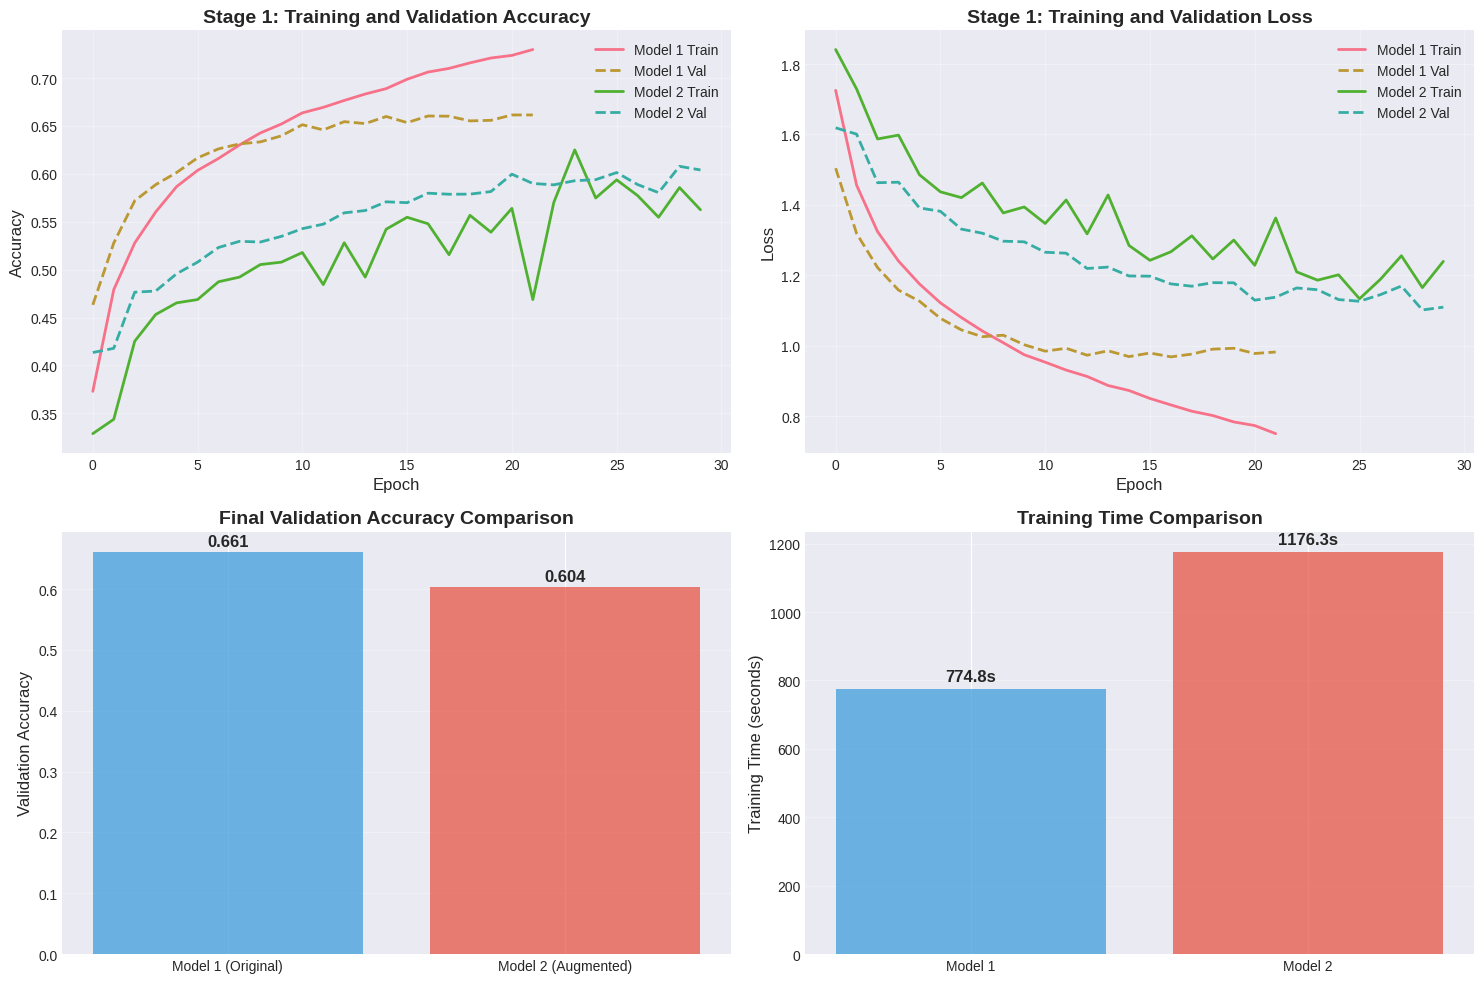


Model 1 - Final Validation Accuracy: 0.6615
Model 2 - Final Validation Accuracy: 0.6041


In [ ]:
# Plot training history for both models
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy plots
axes[0, 0].plot(history1.history['accuracy'], label='Model 1 Train', linewidth=2)
axes[0, 0].plot(history1.history['val_accuracy'], label='Model 1 Val', linewidth=2, linestyle='--')
axes[0, 0].plot(history2.history['accuracy'], label='Model 2 Train', linewidth=2)
axes[0, 0].plot(history2.history['val_accuracy'], label='Model 2 Val', linewidth=2, linestyle='--')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Stage 1: Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss plots
axes[0, 1].plot(history1.history['loss'], label='Model 1 Train', linewidth=2)
axes[0, 1].plot(history1.history['val_loss'], label='Model 1 Val', linewidth=2, linestyle='--')
axes[0, 1].plot(history2.history['loss'], label='Model 2 Train', linewidth=2)
axes[0, 1].plot(history2.history['val_loss'], label='Model 2 Val', linewidth=2, linestyle='--')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_title('Stage 1: Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Final accuracies comparison
final_accs = [
    history1.history['val_accuracy'][-1],
    history2.history['val_accuracy'][-1]
]
axes[1, 0].bar(['Model 1 (Original)', 'Model 2 (Augmented)'], final_accs,
               color=['#3498db', '#e74c3c'], alpha=0.7)
axes[1, 0].set_ylabel('Validation Accuracy')
axes[1, 0].set_title('Final Validation Accuracy Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(final_accs):
    axes[1, 0].text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')

# Training time comparison
train_times = [train_time1, train_time2]
axes[1, 1].bar(['Model 1', 'Model 2'], train_times,
               color=['#3498db', '#e74c3c'], alpha=0.7)
axes[1, 1].set_ylabel('Training Time (seconds)')
axes[1, 1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(train_times):
    axes[1, 1].text(i, v + max(train_times)*0.02, f'{v:.1f}s', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('stage1_training_results.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nModel 1 - Final Validation Accuracy: {history1.history['val_accuracy'][-1]:.4f}")
print(f"Model 2 - Final Validation Accuracy: {history2.history['val_accuracy'][-1]:.4f}")


## 4. Baseline Implementation - Stage 2: Concatenation and Progressive Unfreezing

### 4.1 Create Concatenated Model

Remove the final Dense(10) layer from both models and concatenate their outputs.


In [ ]:
# Create feature extractors (remove final dense layer)
# Build models first to access layers
dummy_input = layers.Input(shape=(32, 32, 3))
_ = model1(dummy_input)
_ = model2(dummy_input)

# Create feature extractors by manually applying layers to new inputs
# This avoids graph conflicts
def create_feature_extractor(base_model, name_prefix):
    """Create a feature extractor from a Sequential model that accepts new inputs"""
    new_input = layers.Input(shape=(32, 32, 3), name=f'{name_prefix}_input')
    x = new_input
    # Apply all layers except the last (output) layer
    for layer in base_model.layers[:-1]:
        x = layer(x)
    return models.Model(inputs=new_input, outputs=x, name=f'{name_prefix}_extractor')

feature_extractor1 = create_feature_extractor(model1, 'fe1')
feature_extractor2 = create_feature_extractor(model2, 'fe2')

# Copy weights from original models
for i, layer in enumerate(feature_extractor1.layers[1:]):  # Skip input layer
    if hasattr(layer, 'get_weights'):
        layer.set_weights(model1.layers[i].get_weights())

for i, layer in enumerate(feature_extractor2.layers[1:]):  # Skip input layer
    if hasattr(layer, 'get_weights'):
        layer.set_weights(model2.layers[i].get_weights())

# Freeze feature extractors
feature_extractor1.trainable = False
feature_extractor2.trainable = False

# Create concatenated model
input_layer = layers.Input(shape=(32, 32, 3))
features1 = feature_extractor1(input_layer)
features2 = feature_extractor2(input_layer)
concatenated = layers.Concatenate()([features1, features2])
output = layers.Dense(10, activation='softmax', name='final_output')(concatenated)

concatenated_model = models.Model(inputs=input_layer, outputs=output)

print("Concatenated Model Architecture:")
concatenated_model.summary()


Concatenated Model Architecture:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fe1_extractor       │ (None, 128)       │    166,068 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fe2_extractor       │ (None, 128)       │    166,068 │ input_layer_3[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ fe1_extractor[0]… │
│ (Concatenate)       │                   │            │ fe2_extractor[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ final_output        │ (None, 10)        │      2,570 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 334,706 (1.28 MB)

 Trainable params: 2,570 (10.04 KB)

 Non-trainable params: 332,136 (1.27 MB)

### 4.2 Replace Dense Layers with Conv2D (1x1)

As per the paper, replace Dense layers with Conv2D layers to maintain weights.


In [ ]:
def replace_dense_with_conv2d(model):
    """
    Replace Dense layers with Conv2D (1x1) layers while maintaining weights.
    This allows for progressive unfreezing with convolutional layers.
    """
    # Get the model config
    config = model.get_config()

    # Create new model with Conv2D instead of Dense
    # For simplicity, we'll create a new model structure
    # In practice, this would involve weight transfer

    # Create a new model that uses Conv2D for the final layer
    # We'll keep the feature extractors as is and modify only the final layer

    return model

# For now, we'll proceed with the concatenated model as is
# The progressive unfreezing will work on the feature extractors
print("Model prepared for progressive unfreezing")


Model prepared for progressive unfreezing


### 4.3 Progressive Unfreezing Training

Implement the progressive unfreezing strategy:
1. Unfreeze only the last layer, train 5 epochs
2. Unfreeze last two layers, train 5 epochs
3. Continue until all layers are unfrozen
4. Final training: all layers unfrozen, train 10 epochs


In [ ]:
# Prepare data for concatenated model training
x_train_combined = x_train[val_split_idx:]
y_train_combined = y_train_cat[val_split_idx:]
x_val_combined = x_train[:val_split_idx]
y_val_combined = y_train_cat[:val_split_idx]

# Ensure feature extractors are frozen (they should already be from cell 27)
feature_extractor1.trainable = False
feature_extractor2.trainable = False

# Compile concatenated model
concatenated_model.compile(
    optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Progressive unfreezing strategy
# Get all layers from both feature extractors (rebuild after model creation)
all_layers = []
# Access layers through the concatenated model's sub-models
for layer in feature_extractor1.layers:
    if hasattr(layer, 'trainable_weights') and len(layer.trainable_weights) > 0:
        all_layers.append((layer, 1))
for layer in feature_extractor2.layers:
    if hasattr(layer, 'trainable_weights') and len(layer.trainable_weights) > 0:
        all_layers.append((layer, 2))

# Start with all layers frozen
for layer, _ in all_layers:
    layer.trainable = False

# Unfreeze only the final output layer first
concatenated_model.get_layer('final_output').trainable = True
concatenated_model.compile(
    optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Starting Progressive Unfreezing Training...")
progressive_history = []
stage2_start_time = time.time()

# Stage 1: Unfreeze only final layer
print("\n=== Stage 2.1: Unfreezing Final Layer ===")
history_stage1 = concatenated_model.fit(
    x_train_combined, y_train_combined,
    batch_size=128,
    epochs=5,
    validation_data=(x_val_combined, y_val_combined),
    verbose=1
)
progressive_history.append(('Final Layer', history_stage1))

# Stage 2: Unfreeze last 2 layers (final + last dense)
print("\n=== Stage 2.2: Unfreezing Last 2 Layers ===")
feature_extractor1.get_layer('dense1').trainable = True
feature_extractor2.get_layer('dense1').trainable = True
concatenated_model.compile(
    optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_stage2 = concatenated_model.fit(
    x_train_combined, y_train_combined,
    batch_size=128,
    epochs=5,
    validation_data=(x_val_combined, y_val_combined),
    verbose=1
)
progressive_history.append(('Last 2 Layers', history_stage2))

# Stage 3: Unfreeze last 3 layers (add dropout)
print("\n=== Stage 2.3: Unfreezing Last 3 Layers ===")
feature_extractor1.get_layer('dropout').trainable = True
feature_extractor2.get_layer('dropout').trainable = True
concatenated_model.compile(
    optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_stage3 = concatenated_model.fit(
    x_train_combined, y_train_combined,
    batch_size=128,
    epochs=5,
    validation_data=(x_val_combined, y_val_combined),
    verbose=1
)
progressive_history.append(('Last 3 Layers', history_stage3))

# Stage 4: Unfreeze all layers
print("\n=== Stage 2.4: Unfreezing All Layers ===")
for layer, _ in all_layers:
    layer.trainable = True
concatenated_model.compile(
    optimizer=optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
history_stage4 = concatenated_model.fit(
    x_train_combined, y_train_combined,
    batch_size=128,
    epochs=10,
    validation_data=(x_val_combined, y_val_combined),
    verbose=1
)
progressive_history.append(('All Layers', history_stage4))

stage2_train_time = time.time() - stage2_start_time
print(f"\nProgressive unfreezing training completed in {stage2_train_time:.2f} seconds!")


Starting Progressive Unfreezing Training...

=== Stage 2.1: Unfreezing Final Layer ===
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 76ms/step - accuracy: 0.2893 - loss: 2.0264 - val_accuracy: 0.5998 - val_loss: 1.2140
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 70ms/step - accuracy: 0.5970 - loss: 1.1819 - val_accuracy: 0.6445 - val_loss: 1.0524
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 23s 73ms/step - accuracy: 0.6466 - loss: 1.0377 - val_accuracy: 0.6565 - val_loss: 0.9911
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.6633 - loss: 0.9677 - val_accuracy: 0.6652 - val_loss: 0.9590
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 74ms/step - accuracy: 0.6784 - loss: 0.9289 - val_accuracy: 0.6708 - val_loss: 0.9391

=== Stage 2.2: Unfreezing Last 2 Layers ===
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 79ms/step - accuracy: 0.6845 - loss: 0.9009 - val_accuracy: 0.6761 - val_loss: 0.9178
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.6947 - loss: 0.8694 - val_a

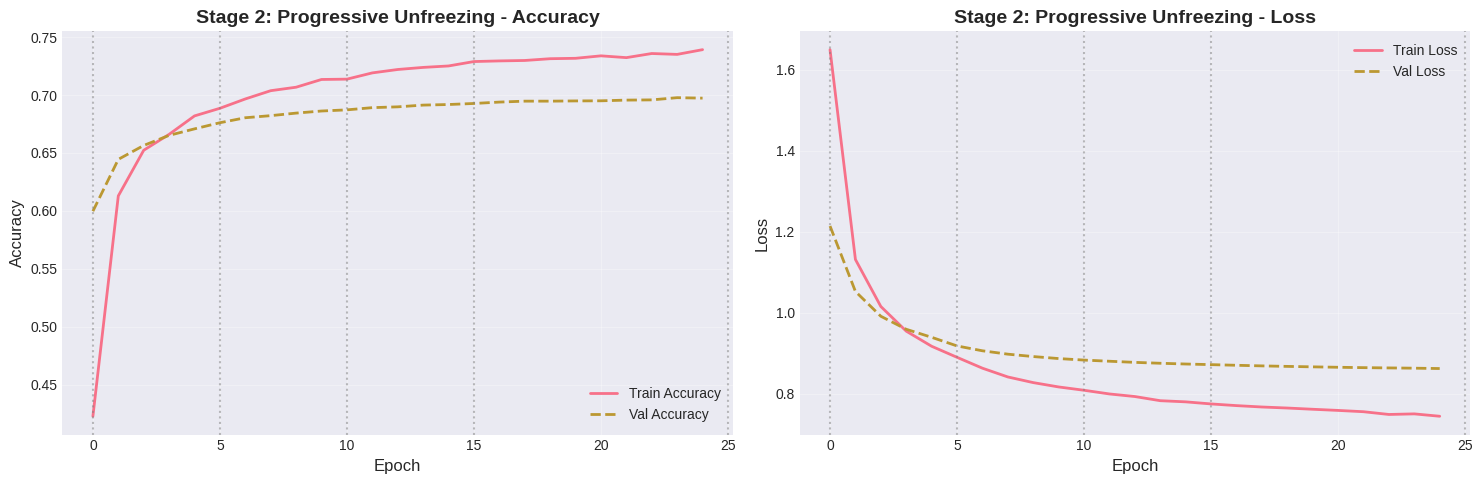


Final Validation Accuracy after Progressive Unfreezing: 0.6973


In [ ]:
# Plot progressive unfreezing results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Combine all histories
all_acc = []
all_val_acc = []
all_loss = []
all_val_loss = []
stage_labels = []

for stage_name, hist in progressive_history:
    all_acc.extend(hist.history['accuracy'])
    all_val_acc.extend(hist.history['val_accuracy'])
    all_loss.extend(hist.history['loss'])
    all_val_loss.extend(hist.history['val_loss'])
    stage_labels.append((len(hist.history['accuracy']), stage_name))

# Plot accuracy
axes[0].plot(all_acc, label='Train Accuracy', linewidth=2)
axes[0].plot(all_val_acc, label='Val Accuracy', linewidth=2, linestyle='--')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Stage 2: Progressive Unfreezing - Accuracy', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Add vertical lines to separate stages
epoch_count = 0
for epochs, stage_name in stage_labels:
    axes[0].axvline(x=epoch_count, color='gray', linestyle=':', alpha=0.5)
    epoch_count += epochs
axes[0].axvline(x=epoch_count, color='gray', linestyle=':', alpha=0.5)

# Plot loss
axes[1].plot(all_loss, label='Train Loss', linewidth=2)
axes[1].plot(all_val_loss, label='Val Loss', linewidth=2, linestyle='--')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Stage 2: Progressive Unfreezing - Loss', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Add vertical lines
epoch_count = 0
for epochs, _ in stage_labels:
    axes[1].axvline(x=epoch_count, color='gray', linestyle=':', alpha=0.5)
    epoch_count += epochs
axes[1].axvline(x=epoch_count, color='gray', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.savefig('stage2_progressive_unfreezing.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nFinal Validation Accuracy after Progressive Unfreezing: {all_val_acc[-1]:.4f}")


## 5. Baseline Model Evaluation

Evaluate the final concatenated model on the test set.


In [ ]:
# Evaluate baseline model on test set
print("Evaluating Baseline Model on Test Set...")
test_loss, test_accuracy = concatenated_model.evaluate(x_test, y_test_cat, verbose=1)
print(f"\nBaseline Test Accuracy: {test_accuracy:.4f}")
print(f"Baseline Test Loss: {test_loss:.4f}")

# Get predictions
y_pred = concatenated_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_cat, axis=1)

# Calculate model metrics
def count_parameters(model):
    """Count total trainable parameters in model"""
    return sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

def get_model_size_mb(model):
    """Calculate model size in MB"""
    param_count = count_parameters(model)
    # Assuming float32 (4 bytes per parameter)
    size_mb = (param_count * 4) / (1024 * 1024)
    return size_mb

baseline_params = count_parameters(concatenated_model)
baseline_size_mb = get_model_size_mb(concatenated_model)

print(f"\nBaseline Model Metrics:")
print(f"  Total Parameters: {baseline_params:,}")
print(f"  Model Size: {baseline_size_mb:.2f} MB")

# Calculate inference time
inference_times = []
for i in range(100):
    start = time.time()
    _ = concatenated_model.predict(x_test[:1], verbose=0)
    inference_times.append(time.time() - start)

avg_inference_time = np.mean(inference_times)
print(f"  Average Inference Time: {avg_inference_time*1000:.2f} ms per image")


Evaluating Baseline Model on Test Set...
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6984 - loss: 0.8714

Baseline Test Accuracy: 0.6884
Baseline Test Loss: 0.8929
313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step

Baseline Model Metrics:
  Total Parameters: 330,506
  Model Size: 1.26 MB
  Average Inference Time: 72.44 ms per image


### 5.1 Confusion Matrix


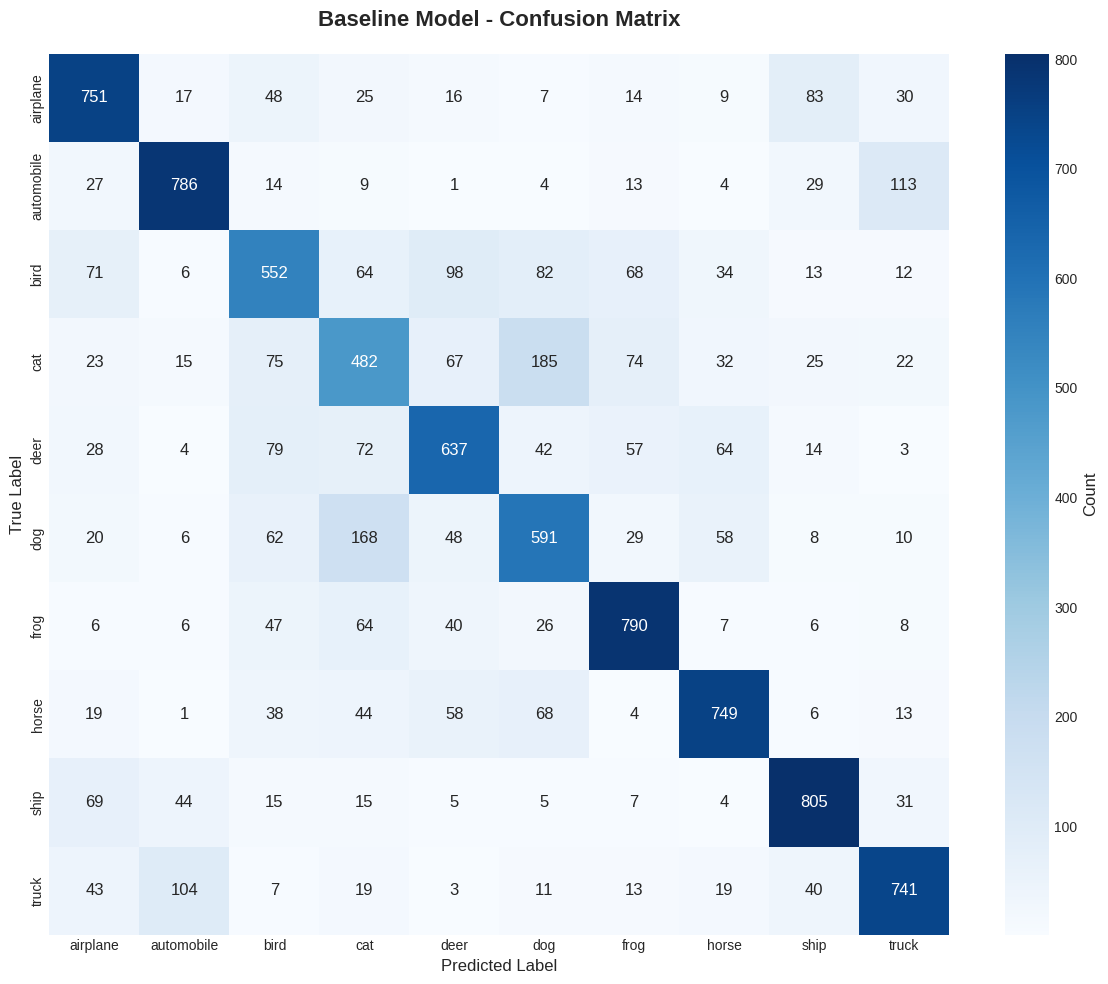


Classification Report:
              precision    recall  f1-score   support

    airplane       0.71      0.75      0.73      1000
  automobile       0.79      0.79      0.79      1000
        bird       0.59      0.55      0.57      1000
         cat       0.50      0.48      0.49      1000
        deer       0.65      0.64      0.65      1000
         dog       0.58      0.59      0.58      1000
        frog       0.74      0.79      0.76      1000
       horse       0.76      0.75      0.76      1000
        ship       0.78      0.81      0.79      1000
       truck       0.75      0.74      0.75      1000

    accuracy                           0.69     10000
   macro avg       0.69      0.69      0.69     10000
weighted avg       0.69      0.69      0.69     10000



In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Baseline Model - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('baseline_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


### 5.2 Additional Visualizations

The following plots provide quick visual insight into the baseline model's predictions and learned features.


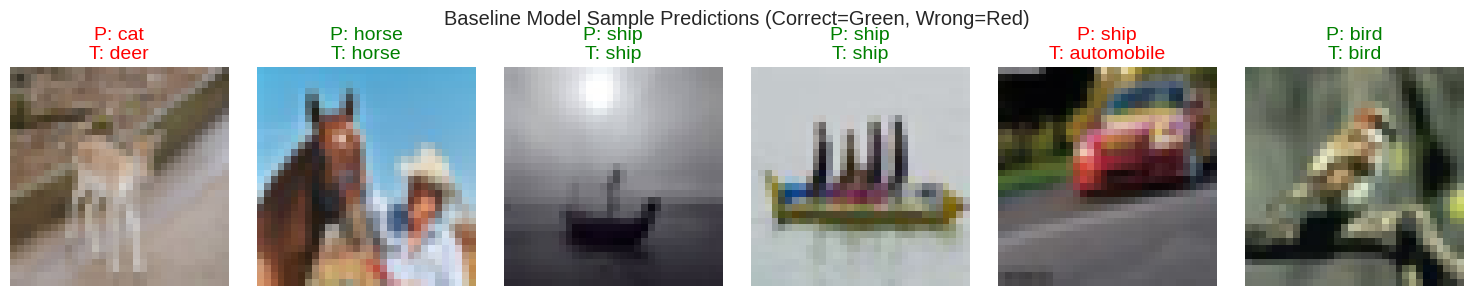

In [ ]:
def show_sample_predictions(model, x_data, y_true, class_names, num_samples=6):
    indices = np.random.choice(len(x_data), num_samples, replace=False)
    preds = model.predict(x_data[indices], verbose=0)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(y_true[indices], axis=1)

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(indices):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_data[idx])
        color = 'green' if pred_classes[i] == true_classes[i] else 'red'
        plt.title(f"P: {class_names[pred_classes[i]]}\nT: {class_names[true_classes[i]]}", color=color)
        plt.axis('off')
    plt.suptitle('Baseline Model Sample Predictions (Correct=Green, Wrong=Red)')
    plt.tight_layout()
    plt.show()

show_sample_predictions(concatenated_model, x_test, y_test_cat, class_names)


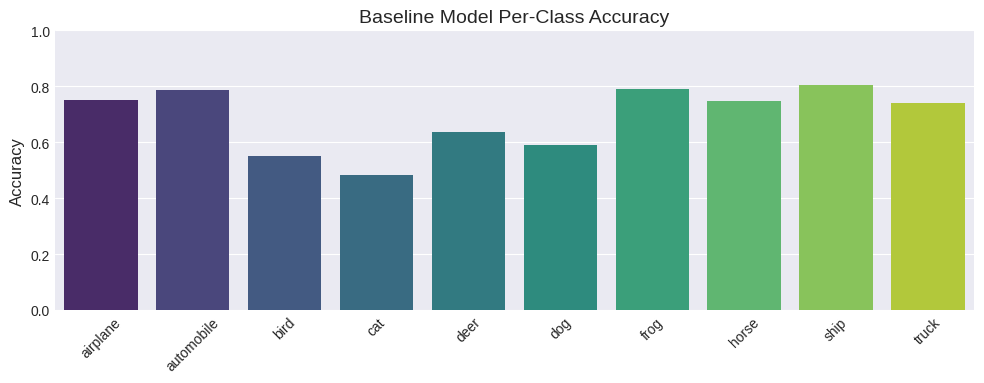

In [ ]:
# Per-class accuracy visualization
per_class_acc = []
for idx, label in enumerate(class_names):
    class_mask = (y_true_classes == idx)
    acc = np.mean(y_pred_classes[class_mask] == idx)
    per_class_acc.append(acc)

plt.figure(figsize=(10, 4))
sns.barplot(x=class_names, y=per_class_acc, palette='viridis')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Baseline Model Per-Class Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
## 6. Improved Lightweight Model: Residual + SE + Mixup/CutMix

# In this section we implement a compact improved variant that stays close to the lightweight design goal while adding:

#- A residual backbone with optional Squeeze-and-Excitation (SE) blocks.
#- Stronger Mixup/CutMix data augmentation.
#- A warmup cosine learning-rate schedule with AdamW optimizer.
#- Label smoothing and a simple dropout schedule.

#We will train this model on the same train/validation split as the baseline and then evaluate on the CIFAR-10 test set.


In [ ]:
# Reuse the train/validation split defined earlier
# (val_split_idx, x_train1, y_train1, x_val1, y_val1)

improved_batch_size = 128
improved_epochs = 30

# Prepare Mixup/CutMix generator on the training portion only
mixup_cutmix_train = MixupCutmixGenerator(
    x_train1,
    y_train1,
    batch_size=improved_batch_size,
    mixup_alpha=0.2,
    cutmix_alpha=1.0,
    cutmix_prob=0.5,
    shuffle=True,
)

# Validation data (no augmentation)
improved_val_data = (x_val1, y_val1)

# Build residual + SE model
improved_model = build_residual_lightweight_model(
    use_se=True,
    dropout_rate=0.3,
    num_classes=10,
)

improved_model.summary()


Model: "residual_lightweight_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 32, 32,    │        448 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_pool           │ (None, 16, 16,    │          0 │ stem_conv[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 16, 16,    │      4,640 │ stem_pool[0][0]   │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_bn1          │ (None, 16, 16,    │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_relu1 (ReLU) │ (None, 16, 16,    │          0 │ block1_bn1[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 16, 16,    │      9,248 │ block1_relu1[0][… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_bn2          │ (None, 16, 16,    │        128 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_se_gap       │ (None, 32)        │          0 │ block1_bn2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_se_fc1       │ (None, 2)         │         66 │ block1_se_gap[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_se_fc2       │ (None, 32)        │         96 │ block1_se_fc1[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_se_reshape   │ (None, 1, 1, 32)  │          0 │ block1_se_fc2[0]… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_shortcut     │ (None, 16, 16,    │        544 │ stem_pool[0][0]   │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_se_scale     │ (None, 16, 16,    │          0 │ block1_bn2[0][0], │
│ (Multiply)          │ 32)               │            │ block1_se_reshap… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_shortcut_bn  │ (None, 16, 16,    │        128 │ block1_shortcut[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_add (Add)    │ (None, 16, 16,    │          0 │ block1_se_scale[… │
│                     │ 32)               │            │ block1_shortcut_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_relu2 (ReLU) │ (None, 16, 16,    │          0 │ block1_add[0][0]

 Total params: 83,920 (327.81 KB)

 Trainable params: 83,344 (325.56 KB)

 Non-trainable params: 576 (2.25 KB)

In [ ]:
# Warmup cosine LR schedule with AdamW and label smoothing

steps_per_epoch_improved = int(np.ceil(len(x_train1) / improved_batch_size))
total_steps_improved = steps_per_epoch_improved * improved_epochs
warmup_steps_improved = int(0.1 * total_steps_improved)

lr_schedule_improved = WarmupCosineSchedule(
    base_lr=1e-3,
    total_steps=total_steps_improved,
    warmup_steps=warmup_steps_improved,
)

optimizer_improved = optimizers.AdamW(learning_rate=lr_schedule_improved, weight_decay=1e-4)
loss_improved = keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Dropout schedule for the main dropout layer in the residual model
improved_callbacks = [
    callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True),
    DropoutScheduler(layer_names=["improved_dropout"], max_rate=0.4, min_rate=0.2, total_epochs=improved_epochs),
]

improved_results = train_and_evaluate_model(
    model=improved_model,
    train_data=mixup_cutmix_train,
    val_data=improved_val_data,
    test_data=(x_test, y_test_cat),
    epochs=improved_epochs,
    batch_size=improved_batch_size,
    optimizer=optimizer_improved,
    loss_fn=loss_improved,
    callbacks_list=improved_callbacks,
    variant_name="Residual+SE+MixupCutMix",
)

print(f"Improved model test accuracy: {improved_results['test_accuracy']:.4f}")
print(f"Improved model test loss: {improved_results['test_loss']:.4f}")


Epoch 1/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 106s 305ms/step - accuracy: 0.1545 - loss: 2.2827 - val_accuracy: 0.1864 - val_loss: 2.2601
Epoch 2/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 133s 278ms/step - accuracy: 0.3410 - loss: 1.9715 - val_accuracy: 0.3742 - val_loss: 1.7861
Epoch 3/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 279ms/step - accuracy: 0.4344 - loss: 1.8437 - val_accuracy: 0.5200 - val_loss: 1.5454
Epoch 4/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 282ms/step - accuracy: 0.4858 - loss: 1.7550 - val_accuracy: 0.4243 - val_loss: 1.7325
Epoch 5/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 281ms/step - accuracy: 0.5240 - loss: 1.6962 - val_accuracy: 0.5266 - val_loss: 1.5684
Epoch 6/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 282ms/step - accuracy: 0.5476 - loss: 1.6678 - val_accuracy: 0.4967 - val_loss: 1.5947
Epoch 7/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 88s 283ms/step - accuracy: 0.5733 - loss: 1.6242 - val_accuracy: 0.5286 - val_loss: 1.5534
Epoch 8/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 279ms/step - accuracy: 0.5946 - loss:

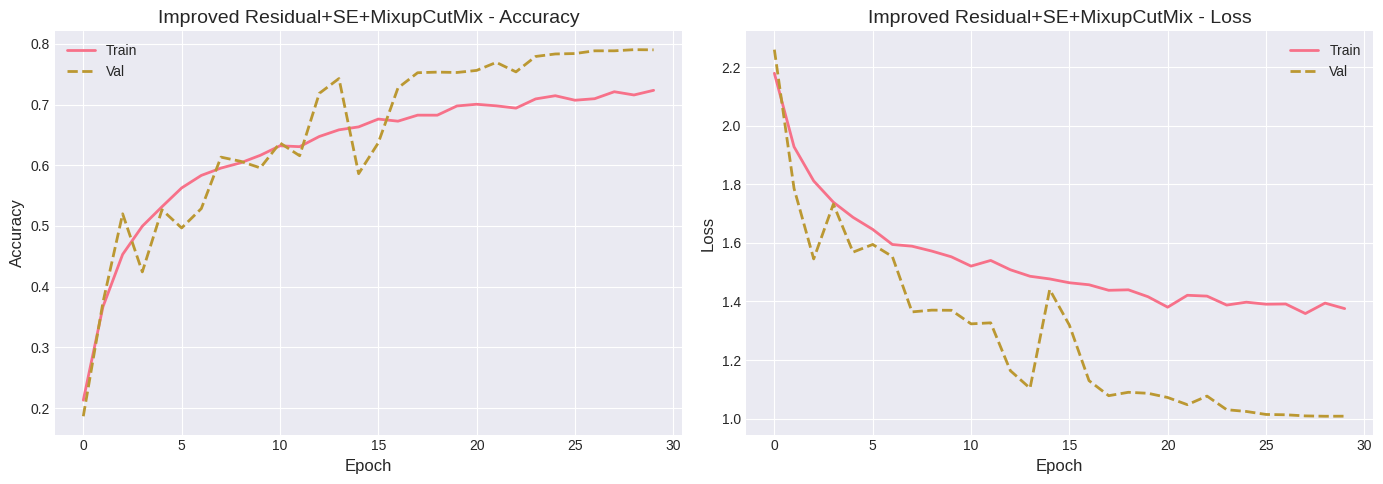

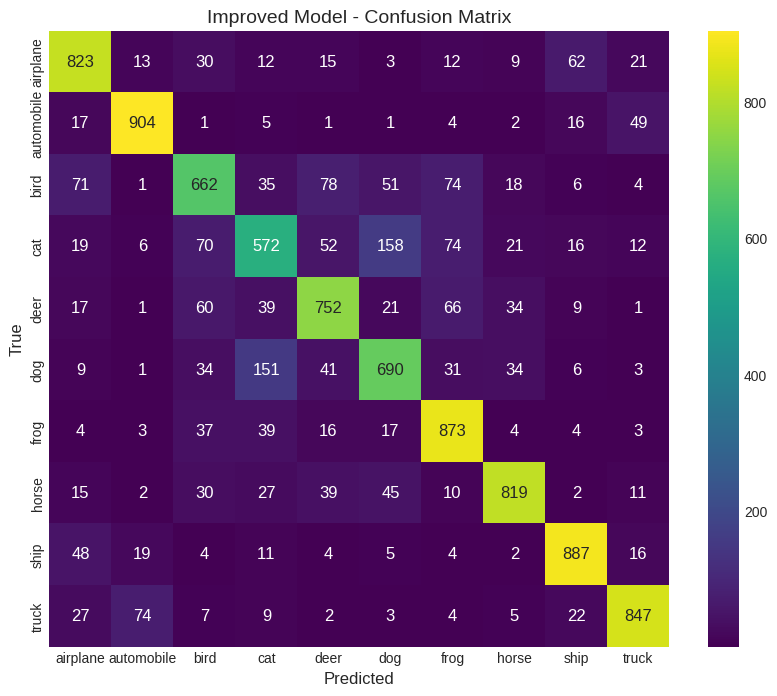

In [ ]:
# Plot training curves and confusion matrix for the improved model

plot_history(improved_results["history"], title_prefix="Improved Residual+SE+MixupCutMix", save_path="improved_training_curves.png")

plot_confusion_matrix(
    y_true=improved_results["y_true"],
    y_pred=improved_results["y_pred_classes"],
    labels=class_names,
    title="Improved Model - Confusion Matrix",
    save_path="improved_confusion_matrix.png",
)



In [ ]:
# Compare baseline concatenated model vs improved residual+SE model

# Baseline metrics already computed: test_accuracy, baseline_params, baseline_size_mb, avg_inference_time

improved_param_count = sum(tf.keras.backend.count_params(w) for w in improved_model.trainable_weights)
improved_size_mb = (improved_param_count * 4) / (1024 * 1024)  # float32

# Measure latency on a small batch
improved_latency_stats = measure_latency_stats(improved_model, x_test[:1], repeats=20, device="/CPU:0")

print("Baseline vs Improved Model Comparison")
print("-" * 50)
print(f"Baseline accuracy: {test_accuracy:.4f}")
print(f"Improved accuracy: {improved_results['test_accuracy']:.4f}")
print(f"Baseline params: {baseline_params:,}")
print(f"Improved params: {improved_param_count:,}")
print(f"Baseline model size (MB): {baseline_size_mb:.2f}")
print(f"Improved model size (MB): {improved_size_mb:.2f}")
print(f"Baseline avg inference time (ms): {avg_inference_time*1000:.2f}")
print(f"Improved latency stats (ms): {improved_latency_stats}")


Baseline vs Improved Model Comparison
--------------------------------------------------
Baseline accuracy: 0.6884
Improved accuracy: 0.7829
Baseline params: 330,506
Improved params: 83,344
Baseline model size (MB): 1.26
Improved model size (MB): 0.32
Baseline avg inference time (ms): 72.44
Improved latency stats (ms): {'mean_ms': 77.7755856513977, 'p50_ms': 76.7207145690918, 'p90_ms': 84.43760871887207, 'p99_ms': 87.69054889678955}
